# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

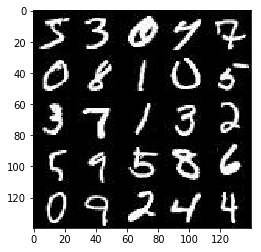

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

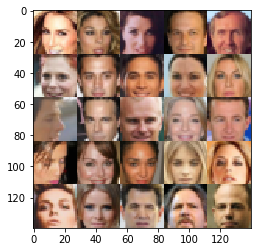

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    pl1 = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input')
    pl2 = tf.placeholder(tf.float32, (None, z_dim), name='Z_Input')
    pl3 = tf.placeholder(tf.float32, name='Learning_Rate')

    return pl1, pl2, pl3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        l1 = tf.maximum(0.2*l1, l1)
        
        l2 = tf.layers.conv2d(l1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(0.2*l2, l2)
        
        l3 = tf.layers.conv2d(l2, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(0.2*l3, l3)
        
        #l3 = tf.nn.dropout(l3, 0.6)
        
        l4 = tf.layers.conv2d(l3, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l4 = tf.layers.batch_normalization(l4, training=True)
        l4 = tf.maximum(0.2*l4, l4)
        
        flat = tf.reshape(l4, (-1,7*7*256))
        logits= tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*256)
        l1 = tf.reshape(l1, (-1,7,7,256))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2*l1,l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5,strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(0.2*l2,l2)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5,strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(0.2*l3,l3)
        
        #l3 = tf.nn.dropout(l3,0.6)
        
        l4 = tf.layers.conv2d_transpose(l3, 64, 5,strides=1, padding='same')
        l4 = tf.layers.batch_normalization(l4, training=is_train)
        l4 = tf.maximum(0.2*l4,l4)
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_v = tf.trainable_variables()
    d_v = [var for var in t_v if 'discriminator' in var.name]
    g_v = [var for var in t_v if 'generator' in var.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_v)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_v)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps=0;
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    figsize=(5,5)
    #tf.reset_default_graph()

    input_real, input_z, learning_rate1 = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z,input_real:batch_images })
                
                steps = steps+1
                train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                train_loss_g = g_loss.eval({input_z:batch_z})
                if steps%10==0:
                    print("Epoch {}".format(epoch_i+1), "Discriminator Loss: {:.3f}".format(train_loss_d), "Generator Loss: {:.3f}".format(train_loss_g))
                
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1 Discriminator Loss: 0.031 Generator Loss: 4.393
Epoch 1 Discriminator Loss: 1.267 Generator Loss: 11.126
Epoch 1 Discriminator Loss: 1.050 Generator Loss: 0.871
Epoch 1 Discriminator Loss: 0.559 Generator Loss: 3.768
Epoch 1 Discriminator Loss: 0.528 Generator Loss: 1.548
Epoch 1 Discriminator Loss: 0.166 Generator Loss: 3.645


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 Discriminator Loss: 0.368 Generator Loss: 2.493
Epoch 1 Discriminator Loss: 0.101 Generator Loss: 6.680
Epoch 1 Discriminator Loss: 0.582 Generator Loss: 1.352
Epoch 1 Discriminator Loss: 1.120 Generator Loss: 0.785
Epoch 1 Discriminator Loss: 0.321 Generator Loss: 2.214
Epoch 1 Discriminator Loss: 0.117 Generator Loss: 5.947
Epoch 1 Discriminator Loss: 0.065 Generator Loss: 5.580
Epoch 1 Discriminator Loss: 0.073 Generator Loss: 5.377
Epoch 1 Discriminator Loss: 0.125 Generator Loss: 11.419
Epoch 1 Discriminator Loss: 1.004 Generator Loss: 0.623


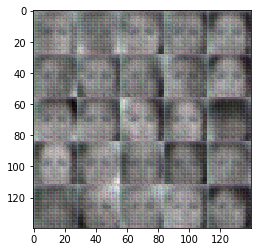

Epoch 1 Discriminator Loss: 3.224 Generator Loss: 0.068
Epoch 1 Discriminator Loss: 0.393 Generator Loss: 2.357
Epoch 1 Discriminator Loss: 0.219 Generator Loss: 8.419
Epoch 1 Discriminator Loss: 0.716 Generator Loss: 0.876
Epoch 1 Discriminator Loss: 0.087 Generator Loss: 3.234
Epoch 1 Discriminator Loss: 0.664 Generator Loss: 1.033
Epoch 1 Discriminator Loss: 0.096 Generator Loss: 9.641
Epoch 1 Discriminator Loss: 0.878 Generator Loss: 0.761
Epoch 1 Discriminator Loss: 0.329 Generator Loss: 7.231
Epoch 1 Discriminator Loss: 0.104 Generator Loss: 4.391


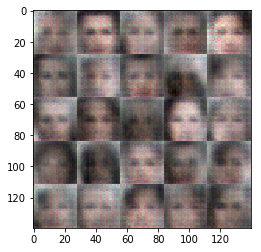

Epoch 1 Discriminator Loss: 0.267 Generator Loss: 8.813
Epoch 1 Discriminator Loss: 0.032 Generator Loss: 6.408
Epoch 1 Discriminator Loss: 0.078 Generator Loss: 7.163
Epoch 1 Discriminator Loss: 0.193 Generator Loss: 11.875
Epoch 1 Discriminator Loss: 0.044 Generator Loss: 10.572
Epoch 1 Discriminator Loss: 1.342 Generator Loss: 0.396
Epoch 1 Discriminator Loss: 0.076 Generator Loss: 5.411
Epoch 1 Discriminator Loss: 3.160 Generator Loss: 0.052
Epoch 1 Discriminator Loss: 0.350 Generator Loss: 7.534
Epoch 1 Discriminator Loss: 2.710 Generator Loss: 0.088


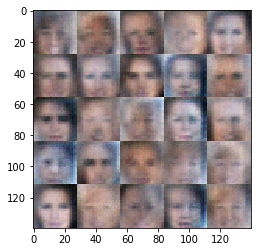

Epoch 1 Discriminator Loss: 0.057 Generator Loss: 7.952
Epoch 1 Discriminator Loss: 0.172 Generator Loss: 3.145
Epoch 1 Discriminator Loss: 0.255 Generator Loss: 7.035
Epoch 1 Discriminator Loss: 0.152 Generator Loss: 12.819
Epoch 1 Discriminator Loss: 0.054 Generator Loss: 7.164
Epoch 1 Discriminator Loss: 0.699 Generator Loss: 10.977
Epoch 1 Discriminator Loss: 1.046 Generator Loss: 0.566
Epoch 1 Discriminator Loss: 0.139 Generator Loss: 9.246
Epoch 1 Discriminator Loss: 0.080 Generator Loss: 10.053
Epoch 1 Discriminator Loss: 0.074 Generator Loss: 5.956


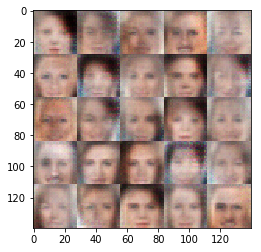

Epoch 1 Discriminator Loss: 1.654 Generator Loss: 0.281
Epoch 1 Discriminator Loss: 0.499 Generator Loss: 1.501
Epoch 1 Discriminator Loss: 0.416 Generator Loss: 13.769
Epoch 1 Discriminator Loss: 0.080 Generator Loss: 5.858
Epoch 1 Discriminator Loss: 0.310 Generator Loss: 2.600
Epoch 1 Discriminator Loss: 0.115 Generator Loss: 4.991
Epoch 1 Discriminator Loss: 0.201 Generator Loss: 6.762
Epoch 1 Discriminator Loss: 0.076 Generator Loss: 7.161
Epoch 1 Discriminator Loss: 0.131 Generator Loss: 6.250
Epoch 1 Discriminator Loss: 0.282 Generator Loss: 6.914


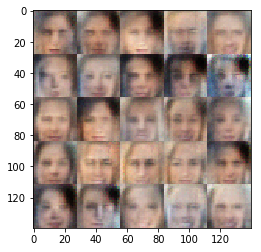

Epoch 1 Discriminator Loss: 0.173 Generator Loss: 11.571
Epoch 1 Discriminator Loss: 0.046 Generator Loss: 8.736
Epoch 1 Discriminator Loss: 1.026 Generator Loss: 1.104
Epoch 1 Discriminator Loss: 0.067 Generator Loss: 11.463
Epoch 1 Discriminator Loss: 0.105 Generator Loss: 6.483
Epoch 1 Discriminator Loss: 0.052 Generator Loss: 7.247
Epoch 1 Discriminator Loss: 0.131 Generator Loss: 4.126
Epoch 1 Discriminator Loss: 0.219 Generator Loss: 12.372
Epoch 1 Discriminator Loss: 0.172 Generator Loss: 10.418
Epoch 1 Discriminator Loss: 0.096 Generator Loss: 4.316


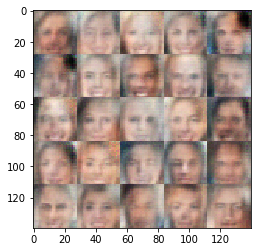

Epoch 1 Discriminator Loss: 0.065 Generator Loss: 7.422
Epoch 1 Discriminator Loss: 1.095 Generator Loss: 6.344
Epoch 1 Discriminator Loss: 0.347 Generator Loss: 3.204
Epoch 1 Discriminator Loss: 0.140 Generator Loss: 4.583
Epoch 1 Discriminator Loss: 0.095 Generator Loss: 9.784
Epoch 1 Discriminator Loss: 0.094 Generator Loss: 5.937
Epoch 1 Discriminator Loss: 0.084 Generator Loss: 6.142
Epoch 1 Discriminator Loss: 0.351 Generator Loss: 3.540
Epoch 1 Discriminator Loss: 1.251 Generator Loss: 8.830
Epoch 1 Discriminator Loss: 0.168 Generator Loss: 4.129


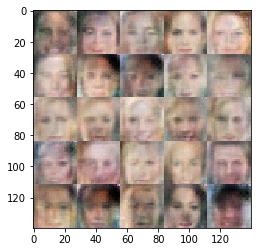

Epoch 1 Discriminator Loss: 0.149 Generator Loss: 5.255
Epoch 1 Discriminator Loss: 0.235 Generator Loss: 2.950
Epoch 1 Discriminator Loss: 0.170 Generator Loss: 4.894
Epoch 1 Discriminator Loss: 0.286 Generator Loss: 9.036
Epoch 1 Discriminator Loss: 0.283 Generator Loss: 4.856
Epoch 1 Discriminator Loss: 0.187 Generator Loss: 6.396
Epoch 1 Discriminator Loss: 0.347 Generator Loss: 3.189
Epoch 1 Discriminator Loss: 0.678 Generator Loss: 1.167
Epoch 1 Discriminator Loss: 0.128 Generator Loss: 4.776
Epoch 1 Discriminator Loss: 0.149 Generator Loss: 13.663


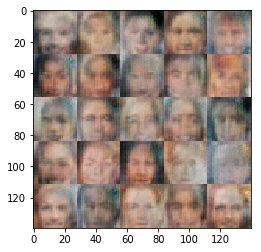

Epoch 1 Discriminator Loss: 0.129 Generator Loss: 6.595
Epoch 1 Discriminator Loss: 0.114 Generator Loss: 7.947
Epoch 1 Discriminator Loss: 1.101 Generator Loss: 0.570
Epoch 1 Discriminator Loss: 0.228 Generator Loss: 2.762
Epoch 1 Discriminator Loss: 0.233 Generator Loss: 11.465
Epoch 1 Discriminator Loss: 0.404 Generator Loss: 6.440
Epoch 1 Discriminator Loss: 0.177 Generator Loss: 11.168
Epoch 1 Discriminator Loss: 0.247 Generator Loss: 3.018
Epoch 1 Discriminator Loss: 0.079 Generator Loss: 10.879
Epoch 1 Discriminator Loss: 0.273 Generator Loss: 7.730


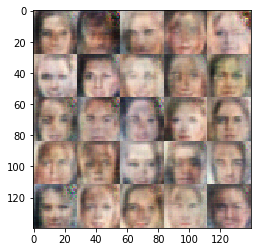

Epoch 1 Discriminator Loss: 0.074 Generator Loss: 6.065
Epoch 1 Discriminator Loss: 0.635 Generator Loss: 4.836
Epoch 1 Discriminator Loss: 0.138 Generator Loss: 10.425
Epoch 1 Discriminator Loss: 0.118 Generator Loss: 5.783
Epoch 1 Discriminator Loss: 0.196 Generator Loss: 7.905
Epoch 1 Discriminator Loss: 0.119 Generator Loss: 7.134
Epoch 1 Discriminator Loss: 0.066 Generator Loss: 5.438
Epoch 1 Discriminator Loss: 0.067 Generator Loss: 8.921
Epoch 1 Discriminator Loss: 0.357 Generator Loss: 1.874
Epoch 1 Discriminator Loss: 0.180 Generator Loss: 4.222


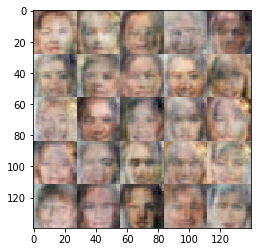

Epoch 1 Discriminator Loss: 0.085 Generator Loss: 10.186
Epoch 1 Discriminator Loss: 0.127 Generator Loss: 9.923
Epoch 1 Discriminator Loss: 1.638 Generator Loss: 2.010
Epoch 1 Discriminator Loss: 0.208 Generator Loss: 7.933
Epoch 1 Discriminator Loss: 0.224 Generator Loss: 6.773
Epoch 1 Discriminator Loss: 0.206 Generator Loss: 6.243
Epoch 1 Discriminator Loss: 0.168 Generator Loss: 4.501
Epoch 1 Discriminator Loss: 0.205 Generator Loss: 10.181
Epoch 1 Discriminator Loss: 0.089 Generator Loss: 9.086
Epoch 1 Discriminator Loss: 0.113 Generator Loss: 11.213


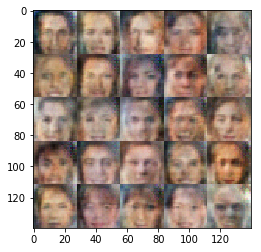

Epoch 1 Discriminator Loss: 0.101 Generator Loss: 10.798
Epoch 1 Discriminator Loss: 0.180 Generator Loss: 8.930
Epoch 1 Discriminator Loss: 0.110 Generator Loss: 12.700
Epoch 1 Discriminator Loss: 0.141 Generator Loss: 9.466
Epoch 1 Discriminator Loss: 1.652 Generator Loss: 0.697
Epoch 1 Discriminator Loss: 1.251 Generator Loss: 6.615
Epoch 1 Discriminator Loss: 0.317 Generator Loss: 4.030
Epoch 1 Discriminator Loss: 0.583 Generator Loss: 9.377
Epoch 1 Discriminator Loss: 0.752 Generator Loss: 4.854
Epoch 1 Discriminator Loss: 0.364 Generator Loss: 8.493


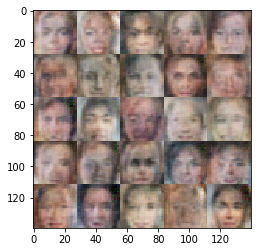

Epoch 1 Discriminator Loss: 0.282 Generator Loss: 3.647
Epoch 1 Discriminator Loss: 0.373 Generator Loss: 3.452
Epoch 1 Discriminator Loss: 0.136 Generator Loss: 10.566
Epoch 1 Discriminator Loss: 0.166 Generator Loss: 7.101
Epoch 1 Discriminator Loss: 0.158 Generator Loss: 7.162
Epoch 1 Discriminator Loss: 0.166 Generator Loss: 9.131
Epoch 1 Discriminator Loss: 0.627 Generator Loss: 1.446
Epoch 1 Discriminator Loss: 0.121 Generator Loss: 8.428
Epoch 1 Discriminator Loss: 0.158 Generator Loss: 10.035
Epoch 1 Discriminator Loss: 0.210 Generator Loss: 19.353


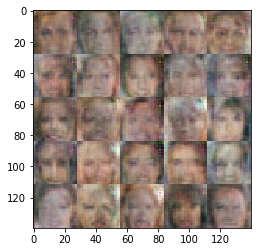

Epoch 1 Discriminator Loss: 0.817 Generator Loss: 2.338
Epoch 1 Discriminator Loss: 0.665 Generator Loss: 3.840
Epoch 1 Discriminator Loss: 0.062 Generator Loss: 8.616
Epoch 1 Discriminator Loss: 0.155 Generator Loss: 8.207
Epoch 1 Discriminator Loss: 0.806 Generator Loss: 5.797
Epoch 1 Discriminator Loss: 0.099 Generator Loss: 9.351
Epoch 1 Discriminator Loss: 0.564 Generator Loss: 1.974
Epoch 1 Discriminator Loss: 0.603 Generator Loss: 5.316
Epoch 1 Discriminator Loss: 1.561 Generator Loss: 11.928
Epoch 1 Discriminator Loss: 0.579 Generator Loss: 2.090


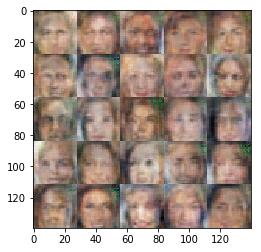

Epoch 1 Discriminator Loss: 0.207 Generator Loss: 3.208
Epoch 1 Discriminator Loss: 0.536 Generator Loss: 1.350
Epoch 1 Discriminator Loss: 0.370 Generator Loss: 2.138
Epoch 1 Discriminator Loss: 0.509 Generator Loss: 3.997
Epoch 1 Discriminator Loss: 0.533 Generator Loss: 3.795
Epoch 1 Discriminator Loss: 2.233 Generator Loss: 1.211
Epoch 1 Discriminator Loss: 0.688 Generator Loss: 1.641
Epoch 1 Discriminator Loss: 0.248 Generator Loss: 4.226
Epoch 1 Discriminator Loss: 0.263 Generator Loss: 4.521
Epoch 1 Discriminator Loss: 0.637 Generator Loss: 5.457


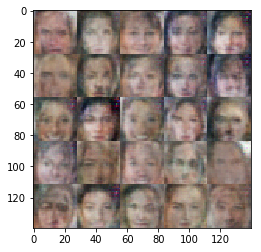

Epoch 1 Discriminator Loss: 0.215 Generator Loss: 7.072
Epoch 1 Discriminator Loss: 0.163 Generator Loss: 7.180
Epoch 1 Discriminator Loss: 1.461 Generator Loss: 9.832
Epoch 1 Discriminator Loss: 1.652 Generator Loss: 1.141
Epoch 1 Discriminator Loss: 0.152 Generator Loss: 6.660
Epoch 1 Discriminator Loss: 0.139 Generator Loss: 7.127
Epoch 1 Discriminator Loss: 0.169 Generator Loss: 4.839
Epoch 1 Discriminator Loss: 0.447 Generator Loss: 2.546
Epoch 1 Discriminator Loss: 0.536 Generator Loss: 1.892
Epoch 1 Discriminator Loss: 0.954 Generator Loss: 10.700


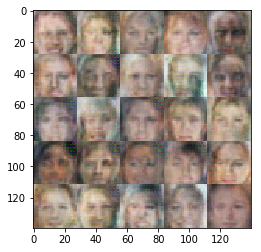

Epoch 1 Discriminator Loss: 0.445 Generator Loss: 1.990
Epoch 1 Discriminator Loss: 0.635 Generator Loss: 2.152
Epoch 1 Discriminator Loss: 0.475 Generator Loss: 1.835
Epoch 1 Discriminator Loss: 2.612 Generator Loss: 2.607
Epoch 1 Discriminator Loss: 0.498 Generator Loss: 5.933
Epoch 1 Discriminator Loss: 0.571 Generator Loss: 2.420
Epoch 1 Discriminator Loss: 0.541 Generator Loss: 1.287
Epoch 1 Discriminator Loss: 0.632 Generator Loss: 1.276
Epoch 1 Discriminator Loss: 0.115 Generator Loss: 6.533
Epoch 1 Discriminator Loss: 1.082 Generator Loss: 6.147


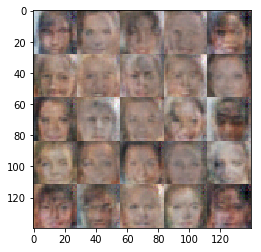

Epoch 1 Discriminator Loss: 0.635 Generator Loss: 10.157
Epoch 1 Discriminator Loss: 0.762 Generator Loss: 4.597
Epoch 1 Discriminator Loss: 0.403 Generator Loss: 2.489
Epoch 1 Discriminator Loss: 0.048 Generator Loss: 13.883
Epoch 1 Discriminator Loss: 0.201 Generator Loss: 4.265
Epoch 1 Discriminator Loss: 0.069 Generator Loss: 10.590
Epoch 1 Discriminator Loss: 0.106 Generator Loss: 4.761
Epoch 1 Discriminator Loss: 0.167 Generator Loss: 3.414
Epoch 1 Discriminator Loss: 0.599 Generator Loss: 1.144
Epoch 1 Discriminator Loss: 0.088 Generator Loss: 6.957


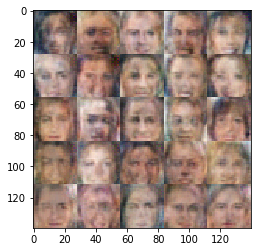

Epoch 1 Discriminator Loss: 0.161 Generator Loss: 4.559
Epoch 1 Discriminator Loss: 0.426 Generator Loss: 1.867
Epoch 1 Discriminator Loss: 0.335 Generator Loss: 5.975
Epoch 1 Discriminator Loss: 0.218 Generator Loss: 6.381
Epoch 1 Discriminator Loss: 0.130 Generator Loss: 5.179
Epoch 1 Discriminator Loss: 0.817 Generator Loss: 1.457
Epoch 1 Discriminator Loss: 0.099 Generator Loss: 12.554
Epoch 1 Discriminator Loss: 0.333 Generator Loss: 7.992
Epoch 1 Discriminator Loss: 0.093 Generator Loss: 9.243
Epoch 1 Discriminator Loss: 0.052 Generator Loss: 10.891


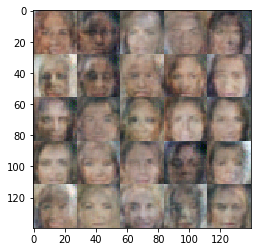

Epoch 1 Discriminator Loss: 0.117 Generator Loss: 6.143
Epoch 1 Discriminator Loss: 0.177 Generator Loss: 9.440
Epoch 1 Discriminator Loss: 2.938 Generator Loss: 3.986
Epoch 1 Discriminator Loss: 1.331 Generator Loss: 0.520
Epoch 1 Discriminator Loss: 0.386 Generator Loss: 7.580
Epoch 1 Discriminator Loss: 0.093 Generator Loss: 9.855
Epoch 1 Discriminator Loss: 0.126 Generator Loss: 6.095
Epoch 1 Discriminator Loss: 0.109 Generator Loss: 8.570
Epoch 1 Discriminator Loss: 1.766 Generator Loss: 0.316
Epoch 1 Discriminator Loss: 2.536 Generator Loss: 0.162


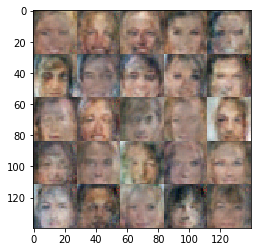

Epoch 1 Discriminator Loss: 0.518 Generator Loss: 4.477
Epoch 1 Discriminator Loss: 0.705 Generator Loss: 1.143
Epoch 1 Discriminator Loss: 0.297 Generator Loss: 2.508
Epoch 1 Discriminator Loss: 0.826 Generator Loss: 1.470
Epoch 1 Discriminator Loss: 0.554 Generator Loss: 3.141
Epoch 1 Discriminator Loss: 1.491 Generator Loss: 0.647
Epoch 1 Discriminator Loss: 0.325 Generator Loss: 2.888
Epoch 1 Discriminator Loss: 0.451 Generator Loss: 6.232
Epoch 1 Discriminator Loss: 0.528 Generator Loss: 2.207
Epoch 1 Discriminator Loss: 0.177 Generator Loss: 3.648


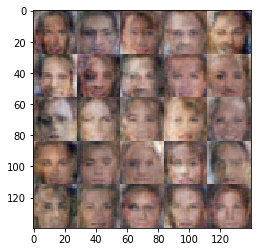

Epoch 1 Discriminator Loss: 3.655 Generator Loss: 7.943
Epoch 1 Discriminator Loss: 1.377 Generator Loss: 0.685
Epoch 1 Discriminator Loss: 0.228 Generator Loss: 5.612
Epoch 1 Discriminator Loss: 1.175 Generator Loss: 1.211
Epoch 1 Discriminator Loss: 0.971 Generator Loss: 1.305
Epoch 1 Discriminator Loss: 1.608 Generator Loss: 7.189
Epoch 1 Discriminator Loss: 0.217 Generator Loss: 4.310
Epoch 1 Discriminator Loss: 0.489 Generator Loss: 11.945
Epoch 1 Discriminator Loss: 1.478 Generator Loss: 0.577
Epoch 1 Discriminator Loss: 1.088 Generator Loss: 0.800


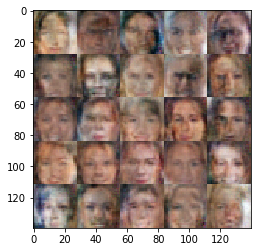

Epoch 1 Discriminator Loss: 0.295 Generator Loss: 3.773
Epoch 1 Discriminator Loss: 0.594 Generator Loss: 1.871
Epoch 1 Discriminator Loss: 0.250 Generator Loss: 4.233
Epoch 1 Discriminator Loss: 0.457 Generator Loss: 2.106
Epoch 1 Discriminator Loss: 0.362 Generator Loss: 13.248
Epoch 1 Discriminator Loss: 0.483 Generator Loss: 10.773
Epoch 1 Discriminator Loss: 0.158 Generator Loss: 10.763
Epoch 1 Discriminator Loss: 0.259 Generator Loss: 3.756
Epoch 1 Discriminator Loss: 0.062 Generator Loss: 7.716
Epoch 1 Discriminator Loss: 0.131 Generator Loss: 9.516


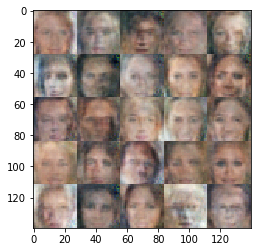

Epoch 1 Discriminator Loss: 0.125 Generator Loss: 8.499
Epoch 1 Discriminator Loss: 1.804 Generator Loss: 0.755
Epoch 1 Discriminator Loss: 0.476 Generator Loss: 7.304
Epoch 1 Discriminator Loss: 0.323 Generator Loss: 2.614
Epoch 1 Discriminator Loss: 0.691 Generator Loss: 1.610
Epoch 1 Discriminator Loss: 0.206 Generator Loss: 4.225
Epoch 1 Discriminator Loss: 0.516 Generator Loss: 4.380
Epoch 1 Discriminator Loss: 0.192 Generator Loss: 4.012
Epoch 1 Discriminator Loss: 0.383 Generator Loss: 2.408
Epoch 1 Discriminator Loss: 0.144 Generator Loss: 7.639


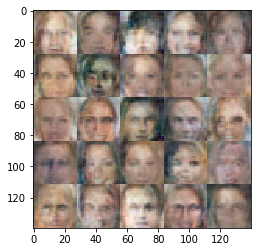

Epoch 1 Discriminator Loss: 0.290 Generator Loss: 5.586
Epoch 1 Discriminator Loss: 0.325 Generator Loss: 12.263
Epoch 1 Discriminator Loss: 0.128 Generator Loss: 10.609
Epoch 1 Discriminator Loss: 0.229 Generator Loss: 4.020
Epoch 1 Discriminator Loss: 0.179 Generator Loss: 6.715
Epoch 1 Discriminator Loss: 0.496 Generator Loss: 2.347
Epoch 1 Discriminator Loss: 0.438 Generator Loss: 4.973
Epoch 1 Discriminator Loss: 0.482 Generator Loss: 8.205
Epoch 1 Discriminator Loss: 0.113 Generator Loss: 10.213
Epoch 1 Discriminator Loss: 0.367 Generator Loss: 2.328


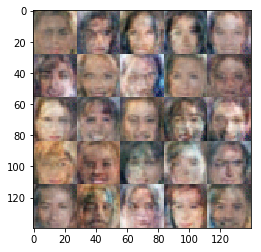

Epoch 1 Discriminator Loss: 0.261 Generator Loss: 3.836
Epoch 1 Discriminator Loss: 0.455 Generator Loss: 2.010
Epoch 1 Discriminator Loss: 0.212 Generator Loss: 5.243
Epoch 1 Discriminator Loss: 0.354 Generator Loss: 2.716
Epoch 1 Discriminator Loss: 0.271 Generator Loss: 4.108
Epoch 1 Discriminator Loss: 0.563 Generator Loss: 14.625
Epoch 1 Discriminator Loss: 0.462 Generator Loss: 2.568
Epoch 1 Discriminator Loss: 0.234 Generator Loss: 11.673
Epoch 1 Discriminator Loss: 0.117 Generator Loss: 9.159
Epoch 1 Discriminator Loss: 0.162 Generator Loss: 9.730


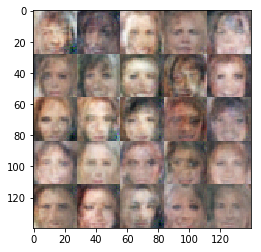

Epoch 1 Discriminator Loss: 0.170 Generator Loss: 12.489
Epoch 1 Discriminator Loss: 0.484 Generator Loss: 3.175
Epoch 1 Discriminator Loss: 1.683 Generator Loss: 0.339
Epoch 1 Discriminator Loss: 0.483 Generator Loss: 2.778
Epoch 1 Discriminator Loss: 0.533 Generator Loss: 6.443
Epoch 1 Discriminator Loss: 0.097 Generator Loss: 5.217
Epoch 1 Discriminator Loss: 0.497 Generator Loss: 2.121
Epoch 1 Discriminator Loss: 0.130 Generator Loss: 9.208
Epoch 1 Discriminator Loss: 0.964 Generator Loss: 2.663
Epoch 1 Discriminator Loss: 1.195 Generator Loss: 1.253


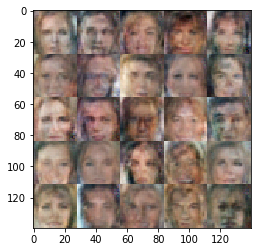

Epoch 1 Discriminator Loss: 0.749 Generator Loss: 12.613
Epoch 1 Discriminator Loss: 2.579 Generator Loss: 0.230
Epoch 1 Discriminator Loss: 1.276 Generator Loss: 0.660
Epoch 1 Discriminator Loss: 0.266 Generator Loss: 8.447
Epoch 1 Discriminator Loss: 0.887 Generator Loss: 7.659
Epoch 1 Discriminator Loss: 0.759 Generator Loss: 1.270
Epoch 1 Discriminator Loss: 0.248 Generator Loss: 5.087
Epoch 1 Discriminator Loss: 0.341 Generator Loss: 6.046
Epoch 1 Discriminator Loss: 0.421 Generator Loss: 4.731
Epoch 1 Discriminator Loss: 0.335 Generator Loss: 3.496


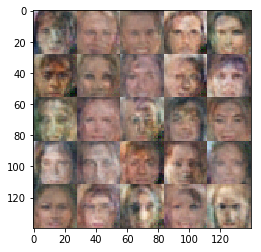

Epoch 1 Discriminator Loss: 1.562 Generator Loss: 9.535
Epoch 1 Discriminator Loss: 0.408 Generator Loss: 2.475
Epoch 1 Discriminator Loss: 0.436 Generator Loss: 2.408
Epoch 1 Discriminator Loss: 0.311 Generator Loss: 4.932
Epoch 1 Discriminator Loss: 0.120 Generator Loss: 7.122
Epoch 1 Discriminator Loss: 0.468 Generator Loss: 1.769
Epoch 1 Discriminator Loss: 0.123 Generator Loss: 7.626
Epoch 1 Discriminator Loss: 0.166 Generator Loss: 14.610
Epoch 1 Discriminator Loss: 0.554 Generator Loss: 1.523
Epoch 1 Discriminator Loss: 0.189 Generator Loss: 12.113


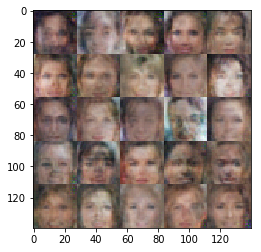

Epoch 1 Discriminator Loss: 0.389 Generator Loss: 1.834
Epoch 1 Discriminator Loss: 0.151 Generator Loss: 8.456
Epoch 1 Discriminator Loss: 0.179 Generator Loss: 4.067
Epoch 1 Discriminator Loss: 0.148 Generator Loss: 7.045
Epoch 1 Discriminator Loss: 0.081 Generator Loss: 8.789
Epoch 1 Discriminator Loss: 0.980 Generator Loss: 10.783
Epoch 1 Discriminator Loss: 0.887 Generator Loss: 4.413
Epoch 1 Discriminator Loss: 0.412 Generator Loss: 3.081
Epoch 1 Discriminator Loss: 0.276 Generator Loss: 4.424
Epoch 1 Discriminator Loss: 2.219 Generator Loss: 0.193


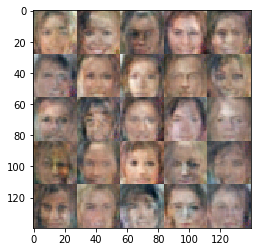

Epoch 1 Discriminator Loss: 0.406 Generator Loss: 2.308
Epoch 1 Discriminator Loss: 0.128 Generator Loss: 7.288
Epoch 1 Discriminator Loss: 0.479 Generator Loss: 2.128
Epoch 1 Discriminator Loss: 0.276 Generator Loss: 4.392
Epoch 1 Discriminator Loss: 1.616 Generator Loss: 4.637
Epoch 1 Discriminator Loss: 0.819 Generator Loss: 1.710
Epoch 1 Discriminator Loss: 0.705 Generator Loss: 8.885
Epoch 1 Discriminator Loss: 0.127 Generator Loss: 7.915
Epoch 1 Discriminator Loss: 0.570 Generator Loss: 15.863
Epoch 1 Discriminator Loss: 0.272 Generator Loss: 5.091


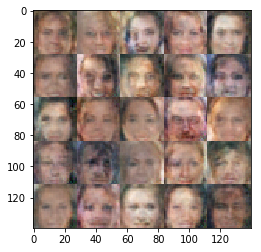

Epoch 1 Discriminator Loss: 0.322 Generator Loss: 2.429
Epoch 1 Discriminator Loss: 0.298 Generator Loss: 4.702
Epoch 1 Discriminator Loss: 0.542 Generator Loss: 3.975
Epoch 1 Discriminator Loss: 0.254 Generator Loss: 4.208
Epoch 1 Discriminator Loss: 0.210 Generator Loss: 7.372
Epoch 1 Discriminator Loss: 0.275 Generator Loss: 4.336


In [118]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.